# Importation des librairies

In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
from datetime import datetime

# Importation des fichiers 

In [234]:
customers = pd.read_csv('customers.csv')
customers.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [235]:
customers.shape

(8623, 3)

In [236]:
products = pd.read_csv('products.csv')
products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [237]:
products.shape

(3287, 3)

In [238]:
transactions = pd.read_csv('transactions.csv')
transactions.head()

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232


In [239]:
transactions.shape

(679532, 4)

# Nettoyage des fichiers

### 1. Valeurs manquantes

In [240]:
print(customers.isnull().sum())
print("-"*20)
print(products.isnull().sum())
print("-"*20)
print(transactions.isnull().sum())

client_id    0
sex          0
birth        0
dtype: int64
--------------------
id_prod    0
price      0
categ      0
dtype: int64
--------------------
id_prod       0
date          0
session_id    0
client_id     0
dtype: int64


* Nous n'avons **pas de données manquantes**.

### 2. Doublons

In [241]:
print(customers.loc[customers[['client_id']].duplicated(keep=False),:])
print("-"*20)
print(products.loc[products[['id_prod']].duplicated(keep=False),:])
print("-"*20)
print(transactions.loc[transactions[['id_prod','date','session_id','client_id']].duplicated(keep=False),:])

Empty DataFrame
Columns: [client_id, sex, birth]
Index: []
--------------------
Empty DataFrame
Columns: [id_prod, price, categ]
Index: []
--------------------
       id_prod                             date session_id client_id
3019       T_0  test_2021-03-01 02:30:02.237419        s_0      ct_0
9668       T_0  test_2021-03-01 02:30:02.237437        s_0      ct_1
10728      T_0  test_2021-03-01 02:30:02.237436        s_0      ct_0
15292      T_0  test_2021-03-01 02:30:02.237430        s_0      ct_0
19312      T_0  test_2021-03-01 02:30:02.237449        s_0      ct_0
...        ...                              ...        ...       ...
653098     T_0  test_2021-03-01 02:30:02.237432        s_0      ct_0
657830     T_0  test_2021-03-01 02:30:02.237417        s_0      ct_0
662081     T_0  test_2021-03-01 02:30:02.237427        s_0      ct_1
671647     T_0  test_2021-03-01 02:30:02.237424        s_0      ct_1
679180     T_0  test_2021-03-01 02:30:02.237425        s_0      ct_1

[183 rows x

Apparement nous avons de doublons pour tous les produits T_0, qui semblent avoir des dates qui commencent par "test".  
Si cette référence produit est égale à un test qui a été fait sur le fichier, il faut éfacer toutes les lignes correspondantes. On voit si c'est bien le cas.

In [242]:
ventes_doublon = transactions.loc[transactions[['id_prod','date','session_id','client_id']].duplicated(keep=False),:]
print(ventes_doublon[ventes_doublon['id_prod'] != 'T_0'])
print("-"*20)
print(ventes_doublon[ventes_doublon['session_id'] != 's_0'])

Empty DataFrame
Columns: [id_prod, date, session_id, client_id]
Index: []
--------------------
Empty DataFrame
Columns: [id_prod, date, session_id, client_id]
Index: []


Toutes les **références produit en doublon** sont bien égales à **'T_0'** et ont leur **identifiant session** égales à **'s_0'**. On regarde si elles sont toutes effectivement des sessions test, c'est-à-dire avec les dates commençant par "test".

In [243]:
print(ventes_doublon[~ventes_doublon['date'].str.startswith("test")])

Empty DataFrame
Columns: [id_prod, date, session_id, client_id]
Index: []


* **Toutes les informations en doublon sont bien des tests qui doivent être éffacées de notre base de données. On les supprime donc de la table "transactions"** :

In [244]:
transactions = transactions.loc[transactions['id_prod'] != 'T_0', :]
print(transactions.isnull().sum())

id_prod       0
date          0
session_id    0
client_id     0
dtype: int64


Nous n'avons plus aucun doublon sur aucune des tables.  
* Vu qu'on sait que la référence 'T_0' est la référence test, **nous allons la supprimer également de la table "products"**.

In [245]:
products = products.loc[products['id_prod'] != 'T_0', :]

### 3. Erreurs de type

In [246]:
print(customers.dtypes)
print("-"*20)
print(products.dtypes)
print("-"*20)
print(transactions.dtypes)

client_id    object
sex          object
birth         int64
dtype: object
--------------------
id_prod     object
price      float64
categ        int64
dtype: object
--------------------
id_prod       object
date          object
session_id    object
client_id     object
dtype: object


* Tout est conforme, sauf le type de de la **colonne "date" de la table "transactions"**. **On la change par du type 'date'**, en ne gardant **que la date sans les heures**, qui ne seront pas importantes pour nos analyses:

In [247]:
transactions['date'] = pd.to_datetime(transactions['date'])
transactions['date']=transactions['date'].dt.date
transactions['date'] = pd.to_datetime(transactions['date'])
print(transactions.dtypes)

id_prod               object
date          datetime64[ns]
session_id            object
client_id             object
dtype: object


### 4. Outliers

In [248]:
print(customers.describe())
print("-"*20)
print(products.describe())
print("-"*20)
print(transactions.describe(datetime_is_numeric=True))

             birth
count  8623.000000
mean   1978.280877
std      16.919535
min    1929.000000
25%    1966.000000
50%    1979.000000
75%    1992.000000
max    2004.000000
--------------------
             price        categ
count  3286.000000  3286.000000
mean     21.863597     0.370359
std      29.849786     0.615446
min       0.620000     0.000000
25%       6.990000     0.000000
50%      13.075000     0.000000
75%      22.990000     1.000000
max     300.000000     2.000000
--------------------
                                date
count                         679332
mean   2022-03-03 03:12:07.300348416
min              2021-03-01 00:00:00
25%              2021-09-08 00:00:00
50%              2022-03-03 00:00:00
75%              2022-08-30 00:00:00
max              2023-02-28 00:00:00


On peut noter quelque chose d'étrange sur la table "transactions" : nous avons des données de transaction pour l'année 2023, qui n'est pas encore arrivé. Regardons les transactions qui sont dans le futur :

In [249]:
transactions.loc[transactions["date"]>"2022-10-31",:].sort_values("date")

,id_prod,date,session_id,client_id
299666,0_1476,2022-11-01,s_290921,c_1609
217061,0_1443,2022-11-01,s_290982,c_5277
132759,0_2207,2022-11-01,s_291026,c_2662
500651,0_161,2022-11-01,s_290913,c_4545
133239,0_1636,2022-11-01,s_291148,c_5120
...,...,...,...,...
396773,0_1431,2023-02-28,s_348128,c_2745
570186,0_1253,2023-02-28,s_348362,c_8301
2838,0_2227,2023-02-28,s_348051,c_403
21930,1_256,2023-02-28,s_348228,c_238


Il y a problablement eu un bug technique ou bien toutes les lignes ci-dessus sont encore des sessions test avec des predictions pour le futur. 
* Dans tous les cas, nous allons **effacer les transactions ayant des dates qui dépassent octobre 2022** pour ne travailler qu'avec les sessions "réelles" :

In [250]:
transactions = transactions.loc[transactions["date"]<"2022-11-01",:]

# Analyses

## 1. Analyses des produits, clients et transactions

Nous alons effectuer toutes nos analyses après avoir fusionné les trois tables.  
Avant, cependant, regardons :
- S'il y a des transactions qui n'ont pas de prix enregistré;
- S'il y a de produits qui n'ont pas été vendus;
- S'il y a de clients qui n'ont jamais rien acheté.  
Començons par une jointure externe des tables "transactions" et "produits" et verrons combien de données il nous manque :

In [251]:
merge_o = transactions.merge(products, how='outer') #Jointure externe pour garder toutes les informations
merge_o.isnull().sum()

id_prod         0
date           21
session_id     21
client_id      21
price         190
categ         190
dtype: int64

In [252]:
pourcentage_pas_vendus = 21*100/3286
pourcentage_pas_vendus

0.6390748630553865

- Il y a **21 produits** qui n'ont pas de corréspondence sur la table "transactions", c'est-à-dire, **n'ont pas été vendus**, soit **0.64% du total des produits**;  
Regardons-les :

In [253]:
merge_sv = merge_o.loc[merge_o['session_id'].isnull(), :] #sans vente
merge_sv

,id_prod,date,session_id,client_id,price,categ
567636,0_1016,NaT,NaN,NaN,35.06,0.0
567637,0_1780,NaT,NaN,NaN,1.67,0.0
567638,0_1062,NaT,NaN,NaN,20.08,0.0
567639,0_1119,NaT,NaN,NaN,2.99,0.0
567640,0_1014,NaT,NaN,NaN,1.15,0.0
567641,1_0,NaT,NaN,NaN,31.82,1.0
567642,0_1318,NaT,NaN,NaN,20.92,0.0
567643,0_1800,NaT,NaN,NaN,22.05,0.0
567644,0_1645,NaT,NaN,NaN,2.99,0.0
567645,0_322,NaT,NaN,NaN,2.99,0.0


La table ci-dessus nous montre tous les produits qui n'ont pas été vendus, soit parce qu'ils sont des nouveaux produits, soit parce que notre public ne sont pas intéressés par eux. En tout cas, on ne va pas considérer ces livres lors de nos analyses, puisque ils ne répresente pas de ventes.

- Il y a **190 transactions** qui n'ont pas de corréspondence sur la table "products", c'est-à-dire, **n'ont pas de prix enregistré sur la base de données**.  
Regardons-les :

In [254]:
merge_sp = merge_o.loc[merge_o['price'].isnull(), :] # sans prix
merge_sp

,id_prod,date,session_id,client_id,price,categ
430214,0_2245,2022-09-23,s_272266,c_4746,NaN,NaN
430215,0_2245,2022-07-23,s_242482,c_6713,NaN,NaN
430216,0_2245,2021-08-16,s_76493,c_1391,NaN,NaN
430217,0_2245,2022-07-16,s_239078,c_7954,NaN,NaN
430218,0_2245,2021-10-20,s_107564,c_1746,NaN,NaN
...,...,...,...,...,...,...
430399,0_2245,2021-08-25,s_80395,c_131,NaN,NaN
430400,0_2245,2022-03-06,s_175311,c_4167,NaN,NaN
430401,0_2245,2022-05-16,s_209381,c_4453,NaN,NaN
430402,0_2245,2022-02-11,s_163405,c_1098,NaN,NaN


Il nous semble que tous les "id_prod" qui manquent des prix sont égales à 0_2245. Verrons si c'est bien le cas :

In [255]:
merge_sp.loc[merge_sp['id_prod'] != '0_2245', :]

,id_prod,date,session_id,client_id,price,categ


Passons aux produits qui sont enregistrés dans la base de données mais qui n'ont pas été vendus :

* **Le seul produit qui a été vendu dont le prix n'est pas enregistré dans la base de données est le livre de référence '0_2245'**.  
Or, si on regarde la table "products", on s'aperçoit que le premier chiffre avant le underscore indique la catégorie à laquelle le livre appartient. 
* Ainsi, **nous alons attribuer le prix de ce produit par une moyenne des prix de catégorie 0, de 11.73 €** :

In [256]:
new_row = pd.DataFrame([['0_2245', 11.73, 0]], columns=['id_prod', 'price', 'categ'])
products = pd.concat([products, new_row])

Nous pouvons, à present, faire une jointure des tables "transactions" et "products" pour ne garder que les informations qui nous intéressent et avec le prix du produit manquant bien rempli :

In [257]:
merge_tp = transactions.merge(products) #Jointure interne : que les produits qui ont été vendus avec leurs prix corréspondants
merge_tp.head()

,id_prod,date,session_id,client_id,price,categ
0,0_1518,2022-05-20,s_211425,c_103,4.18,0
1,0_1518,2021-09-26,s_95811,c_6197,4.18,0
2,0_1518,2021-05-06,s_30782,c_682,4.18,0
3,0_1518,2022-03-16,s_180057,c_5932,4.18,0
4,0_1518,2022-04-22,s_197935,c_4027,4.18,0


Finalement, regardons s'il y a des clients sur la table "clients" qui ne sont pas présents sur la table "transactions", en ajoutant cette dernière à notre table précedente et en regardant les données vides :

In [258]:
merge = merge_tp.merge(customers, how='outer') #Jointure externe pour garder toutes les informations
merge.isnull().sum()

id_prod       23
date          23
session_id    23
client_id      0
price         23
categ         23
sex            0
birth          0
dtype: int64

In [259]:
pourentage_clients_sans_achat = 23*100/8623
pourentage_clients_sans_achat

0.26672851675750897

* Il y a **23 clients** qui **se sont enregistrés sur notre site mais n'ont jamais rien acheté**, soit **0.27% du total des clients**.  
Regardons-les :

In [260]:
merge_sa = merge.loc[merge['session_id'].isnull(), :] # sans achat
merge_sa[['client_id','sex','birth']]

,client_id,sex,birth
567636,c_8253,f,2001
567637,c_3789,f,1997
567638,c_4406,f,1998
567639,ct_0,f,2001
567640,c_2706,f,1967
567641,c_3443,m,1959
567642,c_4447,m,1956
567643,c_3017,f,1992
567644,c_4086,f,1992
567645,c_6930,m,2004


Ainsi, nous avons ces clients qui ne se sont pas sentis concernés par nos produits. Pour nos analyses autour des ventes, on ne va pas les considérer non plus.  
* **Notre table final**, qui **s'appelera "data"**, sera finalement la joiture entre les trois tables où nous pourrons trouver les informations pour chaque session d'achat, avec le client correspondant et ses caractéristiques, ainsi que le produit acheté avec ces caractéristiques :

In [261]:
data = merge_tp.merge(customers) #Jointure interne
data.head()

,id_prod,date,session_id,client_id,price,categ,sex,birth
0,0_1518,2022-05-20,s_211425,c_103,4.18,0,f,1986
1,0_1518,2021-07-20,s_64849,c_103,4.18,0,f,1986
2,0_1518,2022-08-20,s_255965,c_103,4.18,0,f,1986
3,0_1418,2022-06-18,s_225411,c_103,8.57,0,f,1986
4,0_1418,2021-08-18,s_77214,c_103,8.57,0,f,1986


## 2.  Indicateurs et graphiques autour du chiffre d'affaires

### 2.1 CA par produit

On crée la colonne "CA" en groupant les mêmes produits et en faisant la somme de leurs prix :

In [262]:
CA_produit = pd.DataFrame(data.groupby('id_prod')['price'].sum()).reset_index()
CA_produit.rename(columns = {'price':'CA'}, inplace=True)
CA_produit.head()

,id_prod,CA
0,0_0,3877.50
1,0_1,4615.80
2,0_10,305.15
3,0_100,41.20
4,0_1000,2476.08


Regardons les produits qui ont produit les chiffres d'affaires les plus et les moins grands :

#### Top produits

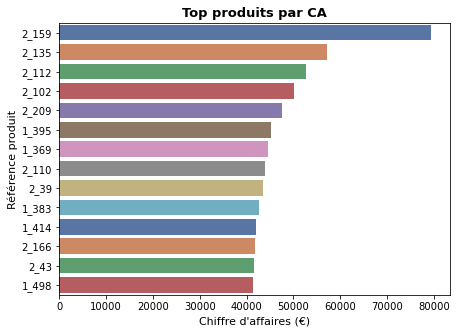

In [263]:
prod_top14 = CA_produit.sort_values('CA', ascending=False).head(14)
plt.figure(figsize=(7,5))
sns.barplot(x=prod_top14['CA'], y=prod_top14['id_prod'], palette ='deep')
plt.title("Top produits par CA", fontsize=13, fontweight='bold')
plt.ylabel("Référence produit", fontsize=11)
plt.xlabel("Chiffre d'affaires (€)", fontsize=11)
plt.show()

* **Nos best sellers nous ont généré chacun plus de 40 000 € depuis l'ouverture de notre boutique en ligne**.

#### Flop produits

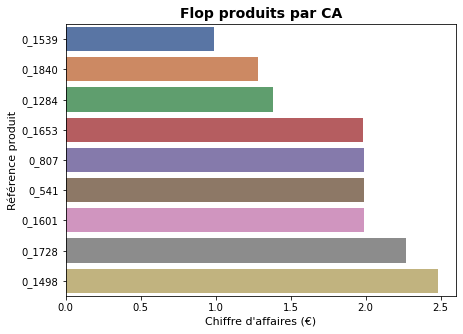

In [264]:
prod_flop9 = CA_produit.sort_values('CA').head(9)
plt.figure(figsize=(7,5))
sns.barplot(x=prod_flop9['CA'], y=prod_flop9['id_prod'], palette ='deep')
plt.title("Flop produits par CA", fontsize=14, fontweight='bold')
plt.ylabel("Référence produit", fontsize=11)
plt.xlabel("Chiffre d'affaires (€)", fontsize=11)
plt.show()

**Tous nos flop livres ont généré des chiffres d'affaires en dessous de 2.5 €**. Ce sont probablement des livres de poche ou en promotion qui n'ont été vendus qu'une seule fois. Regardons s'il y a beaucoup de livres qui nous ont généré des très bas chiffres d'affaires :

In [265]:
CA_produit.loc[CA_produit['CA'] < 10].shape

(90, 2)

In [266]:
pourcentage_flop_produits = (90/3287)*100
pourcentage_flop_produits

2.738059020383328

* **Il y a 90 livres qui ont généré moins de 10 € de chiffres d'affaires chacun, ce qui réprésente 2.74% de nos livres**.

Regardons également la distribution du chiffre d'affaires par livre :

#### Graphique nuage de points CA par produit

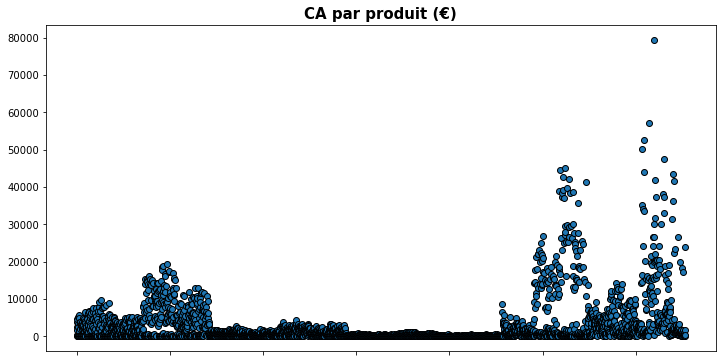

In [267]:
plt.figure(figsize=(12,6))
ca_pp = CA_produit['CA']
plt.scatter(ca_pp.index, CA_produit["CA"], edgecolor='black')
ax = plt.gca()
ax.xaxis.set_tick_params(labelbottom=False)
plt.title("CA par produit (€)", size=15, fontweight='bold')
plt.show()

* **La plupart de nos livres nous ont généré moins de 5 000 € chacun depuis l'ouverture de notre boutique en ligne**.

#### Evolution dans le temps

Nous avons la vision d'ensemble pour toutes les ventes realisées sur notre site.  
Passons à une analyse plus intéressante, celle des ventes dans le temps.  
D'abord, on ne va garder que les dates de notre base de données, sans les heures, qui nous ne seront pas utiles pour cette analyse :

In [268]:
from datetime import datetime
data['date']=data['date'].dt.date
data['date'] = pd.to_datetime(data['date'])

Observons maintenant l'évolution du chiffre d'affaires de mars 2021 à avril 2023 :

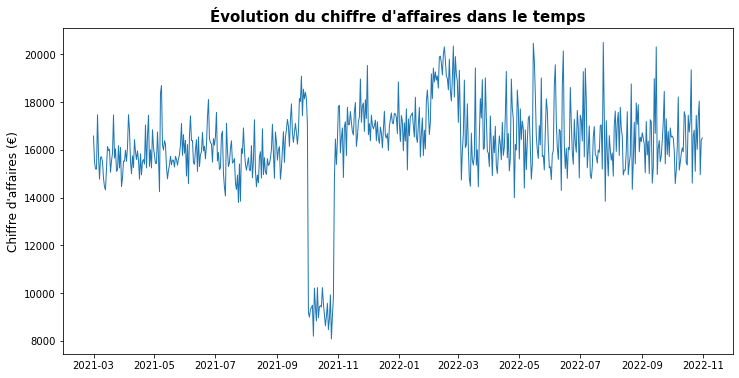

In [269]:
table_date = pd.DataFrame(data.groupby("date")["price"].sum().reset_index()) ; 
plt.figure(figsize=(12,6))
plt.plot(table_date["date"], table_date["price"], linewidth=1)
plt.title("Évolution du chiffre d'affaires dans le temps", fontsize=15, fontweight='bold')
plt.ylabel("Chiffre d'affaires (€)", fontsize=12)
plt.show()

* **Nous avons eu une chute drastique du chiffre d'affaires**, qui est resté plus ou moins stable dans le temps, **au mois d'octobre 2021**.  

Nous alons étudier lors du prochain chapitre les graphiques pour chaque catégorie différente de livres pour voir si on peut en tirer une piste de ce qui c'est passé.

### 2.2 CA par catégorie

#### Prix selon catégories

Faisons d'abord une analyse du prix selon les catégories de livres pour qu'on puisse avoir une idée globale des principales indicateurs, ses histogrammes et ses graphiques boîte à moustache :

----------------------------------------
Catégorie : 0
-> Minimum : 
 0.62
-> Maximum : 
 40.99
-> Moyenne : 
 11.732793417063943
-> Médiane : 
 10.32
-> Mode : 
 0    4.99
Name: price, dtype: float64
-> Ecart-type : 
 7.562477615440926
-> Intercartilles : 
 Q1 =  5.59 et Q3 = 16.65
-> Skewness : 
 0.8389029009262148
-> Kurtosis : 
 0.33389251187387625


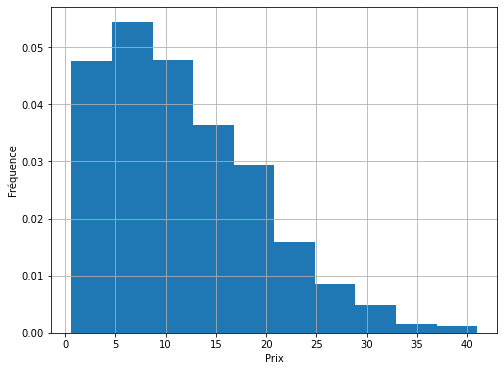

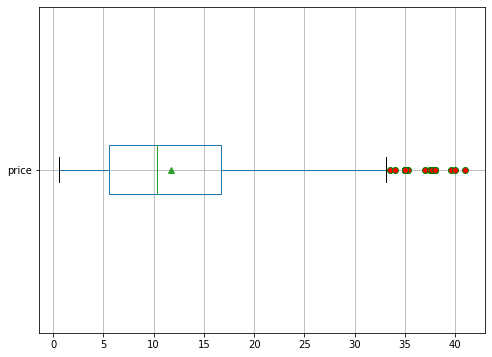

----------------------------------------
Catégorie : 1
-> Minimum : 
 2.0
-> Maximum : 
 80.99
-> Moyenne : 
 25.531420838971624
-> Médiane : 
 22.99
-> Mode : 
 0    22.99
1    32.99
Name: price, dtype: float64
-> Ecart-type : 
 15.414721633623813
-> Intercartilles : 
 Q1 =  13.39 et Q3 = 33.99
-> Skewness : 
 0.8120109621070365
-> Kurtosis : 
 0.2993533794236898


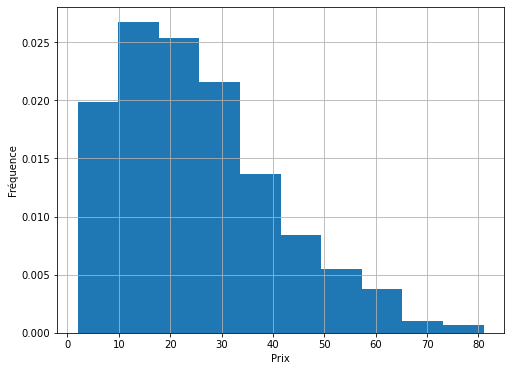

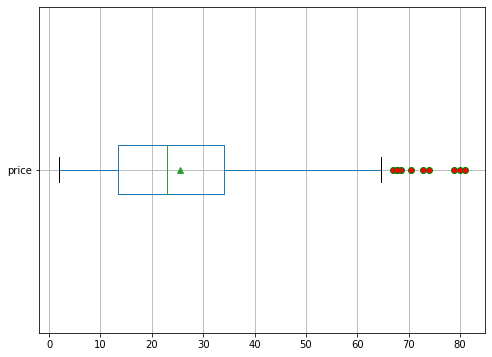

----------------------------------------
Catégorie : 2
-> Minimum : 
 30.99
-> Maximum : 
 300.0
-> Moyenne : 
 108.35468619246883
-> Médiane : 
 101.99
-> Mode : 
 0    50.99
1    68.99
2    69.99
Name: price, dtype: float64
-> Ecart-type : 
 49.45763740520639
-> Intercartilles : 
 Q1 =  71.065 et Q3 = 136.53
-> Skewness : 
 0.9310209579538592
-> Kurtosis : 
 0.808968484300689


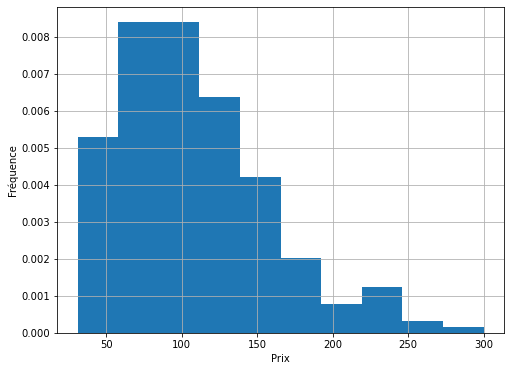

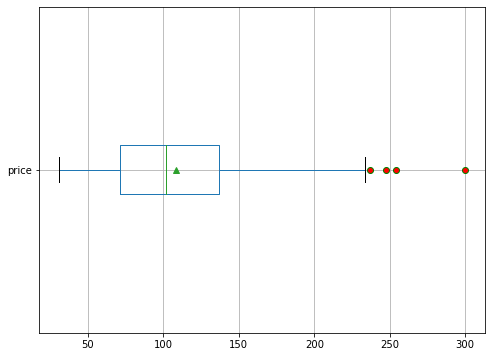

In [270]:
# mesures, histogramme et boite à moustaches par catégorie

for cat in products["categ"].unique():
    subset = products.loc[products.categ == cat, :] # Création du sous-échantillon
    print("-"*40)
    print("Catégorie :", cat)
    print ("-> Minimum : \n", subset['price'].min())
    print("-> Maximum : \n", subset['price'].max())
    print("-> Moyenne : \n",subset['price'].mean())
    print("-> Médiane : \n",subset['price'].median())
    print("-> Mode : \n",subset['price'].mode())
    print("-> Ecart-type : \n", subset['price'].std(ddof=0))
    q3, q1 = np.percentile(subset['price'], [75 ,25])
    print("-> Intercartilles : \n Q1 = ", q1, "et Q3 =", q3)
    print("-> Skewness : \n",subset['price'].skew())
    print("-> Kurtosis : \n",subset['price'].kurtosis())
    plt.figure(figsize=(8,6))
    subset["price"].hist(density=True)
    plt.xlabel("Prix")
    plt.ylabel("Fréquence")
    plt.show()
    plt.figure(figsize=(8,6))
    flierprops = dict(marker='o', markerfacecolor='r', markeredgecolor='g', markersize=6)
    subset.boxplot(column="price", vert=False, showmeans=True, flierprops=flierprops)
    plt.show()

* **Les catégories sont liés aux prix des produits - 0 est la catégorie avec les livres les moins chers et 2 est la catégorie avec les livres les plus chers**.

#### Répartitions

Regardons ensuite la participation par catégorie sur la base de nos produits, sur le total de ventes et sur le chiffre d'affaires :

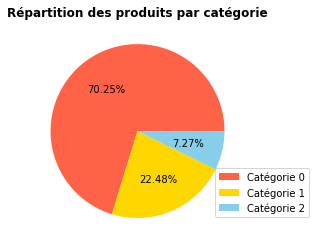

In [271]:
# Diagramme de camembert
plt.pie(products["categ"].value_counts(), autopct='%.2f%%', pctdistance=0.6, colors=['tomato', 'gold', 'skyblue'])
plt.title("Répartition des produits par catégorie", fontsize=12, fontweight='bold')
labels = ['Catégorie 0', 'Catégorie 1', 'Catégorie 2']
plt.legend(labels=labels, loc='lower right', bbox_to_anchor=(1.31, 0.08))
plt.show()

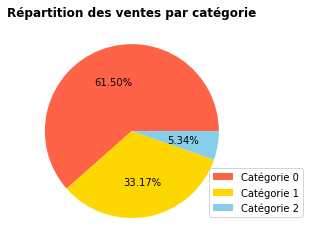

In [272]:
# Diagramme de camembert
plt.pie(data["categ"].value_counts(), autopct='%.2f%%', pctdistance=0.6, colors=['tomato', 'gold', 'skyblue'])
plt.title("Répartition des ventes par catégorie", fontsize=12, fontweight='bold')
labels = ['Catégorie 0', 'Catégorie 1', 'Catégorie 2']
plt.legend(labels=labels, loc='lower right', bbox_to_anchor=(1.31, 0.08))
plt.show()

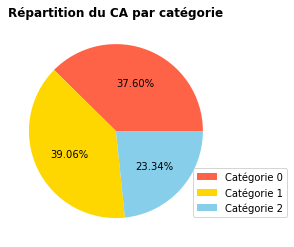

In [273]:
# création de la colonne "CA" en groupant les mêmes catégories et en faisant la somme des prix :
CA_categ = pd.DataFrame(data.groupby('categ')['price'].sum()).reset_index()
CA_categ.rename(columns = {'price':'CA'}, inplace=True)

# Diagramme de camembert
plt.pie(CA_categ["CA"], autopct='%.2f%%', pctdistance=0.6, colors=['tomato', 'gold', 'skyblue'])
plt.title("Répartition du CA par catégorie", fontsize=12, fontweight='bold')
labels = ['Catégorie 0', 'Catégorie 1', 'Catégorie 2']
plt.legend(labels=labels, loc='lower right', bbox_to_anchor=(1.31, 0.08))
plt.show()

* **La catégorie 0, celle dont les livres coûtent en général les moins chers, réprésente la plupart de nos livres en vente en ligne**;
* **La catégorie 1 réprésente la plupart du chiffre d'affaires total**;
* **La catégorie 2, celle dont les livres coûtent en général les plus chers, ont le moins de participation sur le total de livres disponibles en ligne, sur les ventes et sur le chiffre d'affaires**. 

#### Evolution dans le temps

Regardons maintenant l'évolution du CA par catégorie dans le temps :

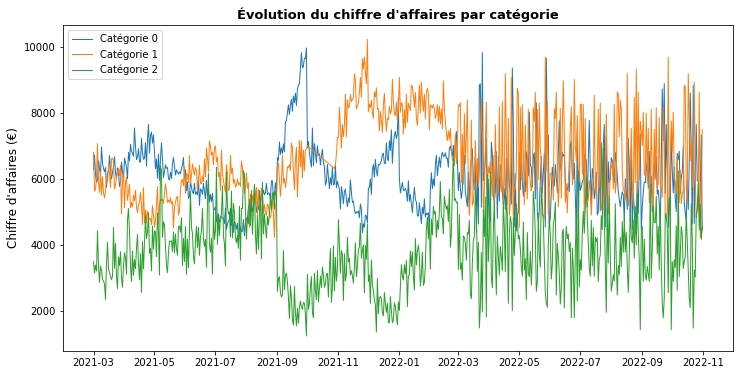

In [274]:
# Graphique en courbes
plt.figure(figsize=(12,6))
for categ in data['categ'].unique() :
    table_categ = pd.DataFrame(data.loc[data['categ']==categ,:].groupby("date")["price"].sum().reset_index())    
    plt.plot(table_categ["date"], table_categ["price"], linewidth=1, label= "Catégorie %d" %categ)

plt.title("Évolution du chiffre d'affaires par catégorie", fontsize=13, fontweight='bold')
plt.ylabel("Chiffre d'affaires (€)", fontsize=12)
plt.legend()
plt.show()

Nous pouvons déjà observer que: 
* **Jusqu'à mars 2022**, il existe une tendance entre les courbes où, **lorsque deux catégories présentent une augmentation temporaire de CA, l'autre présente une diminution, et vice versa**.  
* **Dès septembre 2021** environ, **le CA commence à présenter des courbes très différentes pour chaque catégorie, jusqu'à ce qu'il se normalise à nouveau vers mars 2022**.  

Comme nous avons vu sur le graphique de l'évolution du chiffre d'affaires total dans le temps, celui-ci n'a été vraiment impacté que pendant le mois d'octobre 2021, malgré les fluctuations des autres mois. Nous alons, donc, regarder le **CA du mois d'octobre 2021** de plus près pour chaque catégorie :

In [275]:
# Data pour le mois d'octobre
data_oct = data
data_oct['date'] = data_oct['date'].dt.strftime('%Y-%m-%d')
data_oct = data_oct[data_oct['date'].str.startswith('2021-10')]

# Pivot date pour avoir le CA par catégorie par jour
october=data_oct.pivot_table(index=["date"], columns=["categ"], values=["price"], aggfunc=sum).reset_index().fillna(0)
october.columns=["date", "categ 0", "categ 1", "categ 2"]
october

,date,categ 0,categ 1,categ 2
0,2021-10-01,6950.50,7003.79,3104.05
1,2021-10-02,7141.01,0.00,2041.12
2,2021-10-03,6786.57,0.00,2206.48
3,2021-10-04,6557.06,0.00,2746.08
4,2021-10-05,6357.91,0.00,3032.55
5,2021-10-06,7546.58,0.00,1944.11
6,2021-10-07,6404.01,0.00,1787.07
7,2021-10-08,7069.53,0.00,3137.82
8,2021-10-09,6808.69,0.00,2616.67
9,2021-10-10,6490.98,0.00,2334.67


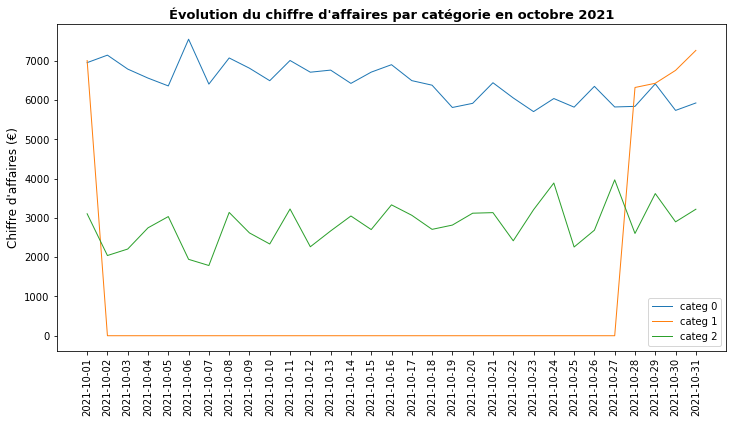

In [276]:
# Graphique en courbes pour le mois d'octobre 2021
plt.figure(figsize=(12,6))
for i in range(3) :
    categ = "categ %d" %i
    plt.plot(october["date"], october[categ], linewidth=1, label= categ)

plt.title("Évolution du chiffre d'affaires par catégorie en octobre 2021", fontsize=13, fontweight='bold')
plt.ylabel("Chiffre d'affaires (€)", fontsize=12)
plt.xticks(rotation = 90)
plt.legend()
plt.show()

* **La cause de la chute du chiffre d'affaires a été un manque de ventes de livres de catégorie 1 de la période du 02 au 27 octobre 2021**.  

La cause peut être un bug lors de l'enregistrement de ces ventes pour cette période, ou bien un manque de disponibilité de cette catégorie de produits sur notre site.

### 2.3 CA par client

On crée la colonne "CA" en groupant les mêmes clients et en faisant la somme des prix :

In [277]:
CA_client = pd.DataFrame(data.groupby('client_id')['price'].sum()).reset_index()
CA_client.rename(columns = {'price':'CA'}, inplace=True)
CA_client.head()

,client_id,CA
0,c_1,482.96
1,c_10,1085.45
2,c_100,254.85
3,c_1000,1755.15
4,c_1001,1448.13


#### Courbe de Lorenz

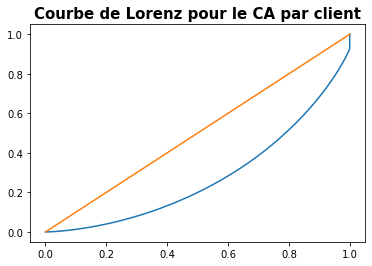

In [278]:
ca = CA_client['CA'].values
n = len(ca)
lorenz = np.cumsum(np.sort(ca)) / ca.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

xaxis = np.linspace(0-1/n,1+1/n,len(lorenz)) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.plot([0,1], [0,1]) #tracer la bisséctrice
plt.title("Courbe de Lorenz pour le CA par client", size=15, fontweight='bold')
plt.show()

Ce graphique nous aide a analyser le profil de nos clients.  
La droite orange représente la situation dans laquelle la distribution du CA par client serait parfaitement égalitaire, c'est-à-dire où chaque client dépenserait le même montant dans notre boutique en ligne.  
Les revenus générés par client ne sont donc pas égalitaires, car la courbe de Lorenz, en bleu, n’est pas diagonale. 
On va calculer  le coefficient de Gini. La formule de calcul de l’indice de Gini est :  
Indice de Gini = A/(A+B).
- A représente la valeur numérique de la surface entre la courbe de Lorenz et la droite diagonale
- B représente la valeur numérique de la surface entre la courbe de Lorenz et l’axe des abscisses.

In [279]:
# indice de Gini
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = 2*S
round(gini,2)

0.45

L’indice est une valeur comprise entre l’intervalle 0 et 1 et lorsque cette valeur est proche de 0, on peut dire que la distribution des revenus dans la population est égalitaire. Par contre, si elle est proche de 1, cette répartition est inégalitaire.  
* **Nos revenus sont** donc **plutôt inégalitaires : les revenus sont plus concentrés chez une partie de nos clients.**  

Regardons donc nos top 10 clients pour voir s'il y a des écarts très grands :

#### **Top 10 clients**

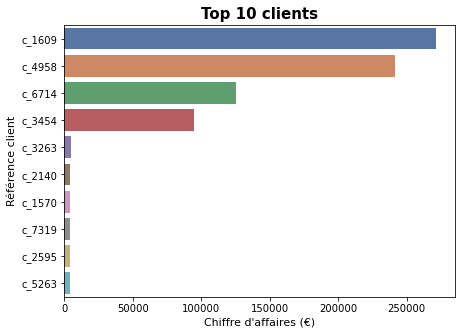

In [280]:
clients_top10 = CA_client.sort_values('CA', ascending=False).head(10)
plt.figure(figsize=(7,5))
sns.barplot(x=clients_top10['CA'], y=clients_top10['client_id'], palette ='deep')
plt.title("Top 10 clients", fontsize=15, fontweight='bold')
plt.ylabel("Référence client", fontsize=11)
plt.xlabel("Chiffre d'affaires (€)", fontsize=11)
plt.show()

Nous voyons donc très clairement **4 clients** qui **ont depensé plus de 80 000 € chacun sur notre site**. L'écart entre ces clients et nos autres clients étant très grand, on peut conclure qu'il s'agit de comptes entreprise, probablement des revendeurs ou propriétaires des librairies ou écoles, par exemple. Pour ne pas fausser le restant de nos analyses, **nous allons les considérer comme des outliers et les éffacer de notre base de données**.

In [282]:
data = data.loc[(data['client_id'] != 'c_1609') & (data['client_id'] != 'c_4958') 
         & (data['client_id'] != 'c_6714') & (data['client_id'] != 'c_3454')]

Regardons maintenant notre top 10 et flop 10 clients et le graphique en nuage de points du CA par client :

#### Top clients

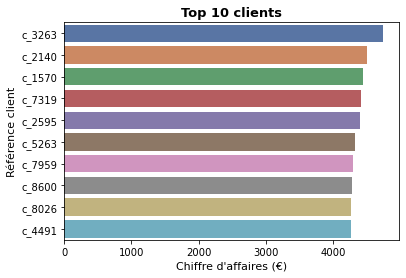

In [283]:
CA_client = pd.DataFrame(data.groupby('client_id')['price'].sum()).reset_index()
CA_client.rename(columns = {'price':'CA'}, inplace=True)
clients_top10 = CA_client.sort_values('CA', ascending=False).head(10)
plt.figure(figsize=(6,4))
sns.barplot(x=clients_top10['CA'], y=clients_top10['client_id'], palette ='deep')
plt.title("Top 10 clients", fontsize=13, fontweight='bold')
plt.ylabel("Référence client", fontsize=11)
plt.xlabel("Chiffre d'affaires (€)", fontsize=11)
plt.show()

In [284]:
CA_client[CA_client['CA']>4000].shape

(23, 2)

#### Flop CA par clients

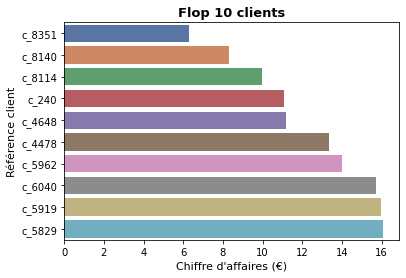

In [285]:
CA_client = pd.DataFrame(data.groupby('client_id')['price'].sum()).reset_index()
CA_client.rename(columns = {'price':'CA'}, inplace=True)
clients_flop10 = CA_client.sort_values('CA').head(10)
plt.figure(figsize=(6,4))
sns.barplot(x=clients_flop10['CA'], y=clients_flop10['client_id'], palette ='deep')
plt.title("Flop 10 clients", fontsize=13, fontweight='bold')
plt.ylabel("Référence client", fontsize=11)
plt.xlabel("Chiffre d'affaires (€)", fontsize=11)
plt.show()

#### Graphique nuage de points CA par client

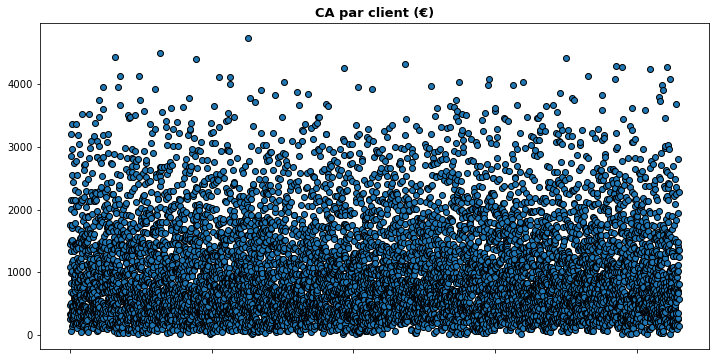

In [286]:
plt.figure(figsize=(12,6))
ca_pc = CA_client['CA']
plt.scatter(CA_client.index, CA_client["CA"], edgecolor='black')
ax = plt.gca()
ax.xaxis.set_tick_params(labelbottom=False)
plt.title("CA par client (€)", size=13, fontweight='bold')
plt.show()

* Nous voyons une distribution plus égalitaire du CA entre nos clients sans les 4 outliers. **Nos clients les plus fidèles ont tous dépensé plus de 4 000 € chacun en total sur notre boutique en ligne**.

### 2.4 CA par âge

#### Répartitions

Regardons la participation par âge sur la base de nos clients, sur le total de ventes et sur le chiffre d'affaires :

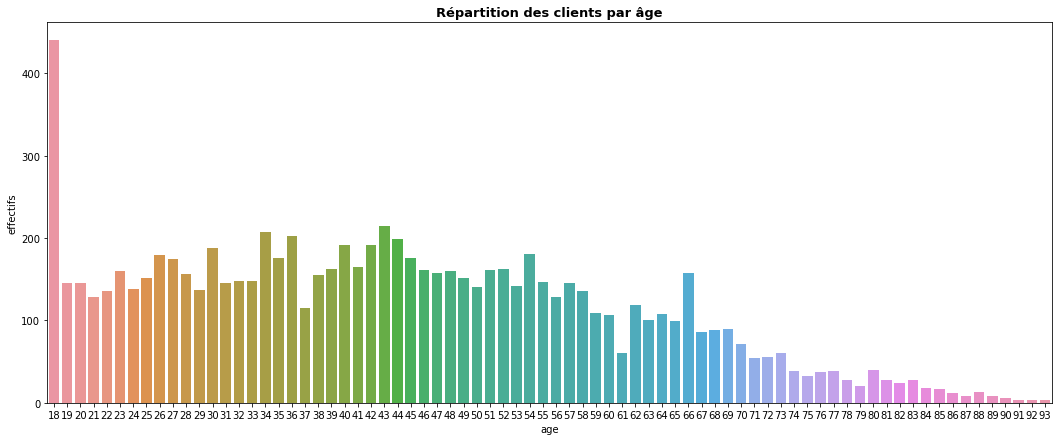

In [287]:
# Création de la colonne "âge"
customers['age'] = 2022 - customers['birth']

# Effectifs par âge
age_eff= customers['age'].value_counts().reset_index()
age_eff.rename(columns={"index": "age", "age":"effectifs"}, inplace=True)

# Répartition de nos clients par âge
plt.figure(figsize=(18,7))
sns.barplot(data=age_eff, y='effectifs', x='age')
plt.title('Répartition des clients par âge', size=13, fontweight='bold')
plt.show()

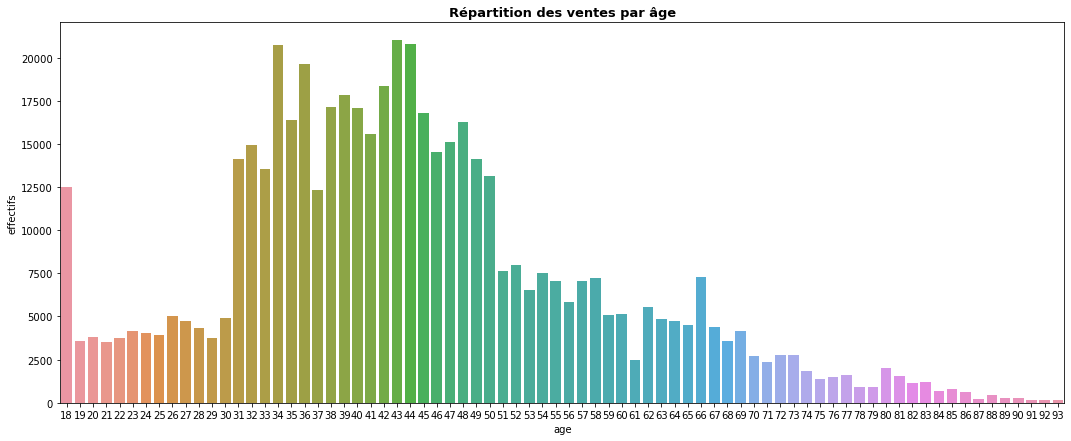

In [288]:
# Création de la colonne "âge"
data['age'] = 2022 - data['birth']

# Effectifs par âge
age_ventes= data['age'].value_counts().reset_index()
age_ventes.rename(columns={"index": "age", "age":"effectifs"}, inplace=True)

# Répartition des ventes par âge
plt.figure(figsize=(18,7))
sns.barplot(data=age_ventes, y='effectifs', x='age')
plt.title('Répartition des ventes par âge', size=13, fontweight='bold')
plt.show()

In [289]:
# CA par âge
CA_age = pd.DataFrame(data.groupby('age')['price'].sum()).reset_index()
CA_age.rename(columns = {'price':'CA'}, inplace=True)
CA_age.head()

,age,CA
0,18,500123.91
1,19,149000.11
2,20,151383.56
3,21,146856.33
4,22,138874.00


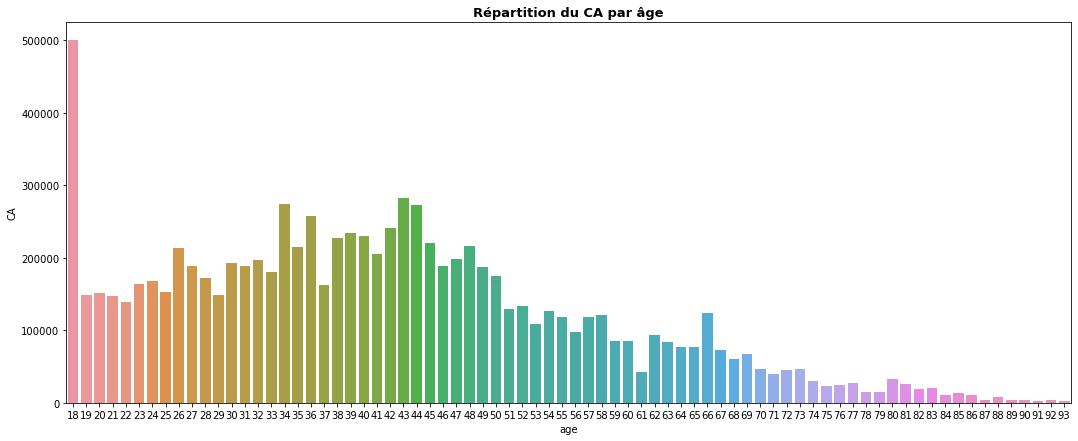

In [290]:
#Répartition du CA par âge
plt.figure(figsize=(18,7))
sns.barplot(data=CA_age, y='CA', x='age')
plt.title('Répartition du CA par âge', size=13, fontweight='bold')
plt.show()

* **Les clients de 18 ans sont la grande majeurité de nos clients et ont généré également la grande majeurité du chiffre d'affaires**.  Ces clients sont probablement des personnes qui rentrent dans leur première anné du Bac, donc qui dépensent beaucoup plus que le restant de nos clients;
* **Les clients âgés entre 31 et 50 ans ont effectué la plupart des ventes**;
* **Après l'âge de 18 ans, les chiffres d'affaires les plus grands sont observés entre 26 et 50 ans**.
* **Les clients senior sont très peu présents sur notre base de données. Ils ont également effectué peu d'achats et ont une faible participation sur le chiffre d'affaires**.

### 2.4 CA par genre

Regardons la participation par genre sur la base de nos clients, sur le total de ventes et sur le chiffre d'affaires :

#### Répartition

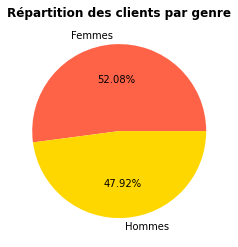

In [291]:
# Répartition des clients par genre
labels = ['Femmes', 'Hommes']
plt.pie(customers["sex"].value_counts(), autopct='%.2f%%', labels=labels, pctdistance=0.6, colors=['tomato', 'gold'])
plt.title("Répartition des clients par genre", fontsize=12, fontweight='bold')
plt.show()

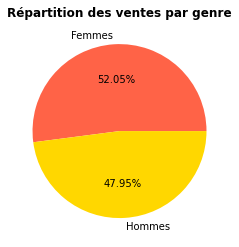

In [292]:
# Répartition des ventes par genre
labels = ['Femmes', 'Hommes']
plt.pie(data["sex"].value_counts(), autopct='%.2f%%', labels=labels, pctdistance=0.6, colors=['tomato', 'gold'])
plt.title("Répartition des ventes par genre", fontsize=12, fontweight='bold')
plt.show()

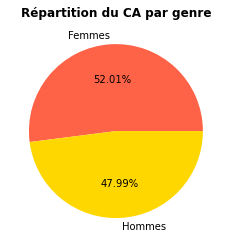

In [293]:
# Répartition du CA par genre

# création de la colonne "CA" en groupant les mêmes catégories et en faisant la somme des prix :
CA_genre = pd.DataFrame(data.groupby('sex')['price'].sum()).reset_index()
CA_genre.rename(columns = {'price':'CA'}, inplace=True)

# Diagramme de camembert
labels = ['Femmes', 'Hommes']
plt.pie(CA_genre["CA"], autopct='%.2f%%', labels=labels, pctdistance=0.6, colors=['tomato', 'gold'])
plt.title("Répartition du CA par genre", fontsize=12, fontweight='bold')
plt.show()

* **Les femmes et les hommes ont une participation presque pareil, avec légèrement plus de participation de femmes sur la base de clients, le total de ventes et le chiffre d'affaires**.

## 3. Corrélations : analyse des comportements clients

 ### 3.1 Lien entre le genre d’un client et les catégories des livres achetés 

On va analyser cette corrélation avec le Chi-2.  
On commence par afficher le tableau de contingence :

In [294]:
X = "sex"
Y = "categ"

cont = data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
cont

categ,0,1,2,Total
sex,,,,
f,168723,92421,14073,275217
m,156693,83605,13192,253490
Total,325416,176026,27265,528707


Et on crée le heatmap (carte de chaleur) :

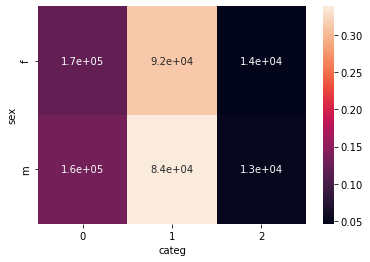

In [295]:
tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = len(data)
indep = tx.dot(ty) / n

measure = (cont-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=cont.iloc[:-1,:-1])
plt.show()

On obtient chaque case une valeur comprise entre 0 et 1, qui nous sert à étalonner la couleur. On peut considérer cette valeur comme une contribution à la non-indépendance. Plus cette contribution sera proche de 1, plus la case en question sera source de non-indépendance. La somme de toutes les contributions vaut 1. Ainsi :
* **Les femmes semblent s'intéresser plus aux catégories 0 et 1, tandis que la catégorie 2 intéresse également aux deux genres**.
* **La catégorie la plus fortement lié au genre est la catégorie 0 et la moins lié est la catégorie 2**.

On calcule la statistique ξn pour appliquer à cette mesure un seuil au-delà duquel on dira que les 2 variables sont corrélées ( test du χ2).

In [296]:
print("ξn =", round(xi_n,2))

ξn = 21.9


ξn est supérieur à la valeur de référence sur la table du χ2 pour une probabilité d'erreur inférieur à 1 % et dégré de liberté égal à 2.
* **On peut être certains à plus de 99% que nos deux variables ne sont pas indépendantes**.

### 3.2 Lien entre l’âge des clients et le montant total des achats

Nous savons déjà que l'âge de 18 ans est très fortement correlé à toutes les variables qu'on va analyser, comme nous avons vu lors de l'analyse du CA par âge. Ainsi, pour ne pas fausser nos analyses à partir d'ici, nous allons da rétirer de notre base de données.

In [297]:
data = data.loc[data["age"] != 18]

On va analyser le lien entre l’âge des clients et le montant total des achats par régression linéaire.  
On commence par grouper le montant d'achat selon nos clients :

In [327]:
# montant par client
montant = data.groupby(['client_id', 'age'])['price'].sum().reset_index()
montant.rename(columns={'price':'montant'}, inplace=True)
montant.head()

,client_id,age,montant
0,c_1,67,482.96
1,c_10,66,1085.45
2,c_100,30,254.85
3,c_1000,56,1755.15
4,c_1001,40,1448.13


Puis on affiche le diagramme de dispersion avec l'âge de chaque client et le montant dépensé :

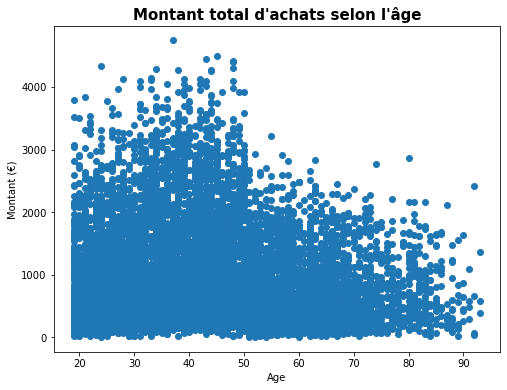

In [328]:
plt.figure(figsize=(8,6))
plt.plot(montant['age'],montant['montant'], "o")
plt.xlabel("Age")
plt.ylabel("Montant (€)")
plt.title("Montant total d'achats selon l'âge", size=15, fontweight='bold')
plt.show()

In [300]:
print("Covariance :", round((np.cov(montant["age"],montant["montant"],ddof=0)[1,0]),2))
print("Pearson :", round((st.pearsonr(montant["age"],montant["montant"])[0]),2))

Covariance : -2507.47
Pearson : -0.19


Selon le graphique :
* **Les personnes âgés entre 30 et 50 ans achètent les plus gros montants de notre base de données**.
* **Les montants d'achats maximums ont une tendance à diminuer à partir de 50 ans**.  

Le Pearson étant de -0.2 nous dit qu'il y a une forte correlation entre le montant d'achat et l'âge de nos clients. Par contre, nous ne pouvons pas tracer une ligne droite par régréssion linéaire sur l'ensemble des données car nous avons des tendances différentes selon des tranches d'âge différentes. 
Nous allons donc diviser la variable "âge" par tranches, et cette fois-ci on représente pour chaque tranche une boîte à moustaches calculée à partir de tous les points présents dans la tranche.  

In [329]:
# création d'une liste de conditions
conditions = [
    (data['age'] <= 30),
    (data['age'] > 30) & (data['age'] <= 50),
    (data['age'] > 50)
    ]

# création d'une liste avec les tranches d'âge
values = ['entre 19 et 30 ans', 'entre 31 et 50 ans', 'entre 51 et 93 ans']

# création de la colonne "tranche d'age"
data["tranche d'age"] = np.select(conditions, values)

# display updated DataFrame
data.head()

,id_prod,date,session_id,client_id,price,categ,sex,birth,age,tranche d'age,taille_panier,mois
0,0_1518,2022-05-20,s_211425,c_103,4.18,0,f,1986,36,entre 31 et 50 ans,2,5
1,0_1518,2021-07-20,s_64849,c_103,4.18,0,f,1986,36,entre 31 et 50 ans,2,7
2,0_1518,2022-08-20,s_255965,c_103,4.18,0,f,1986,36,entre 31 et 50 ans,2,8
3,0_1418,2022-06-18,s_225411,c_103,8.57,0,f,1986,36,entre 31 et 50 ans,3,6
4,0_1418,2021-08-18,s_77214,c_103,8.57,0,f,1986,36,entre 31 et 50 ans,3,8


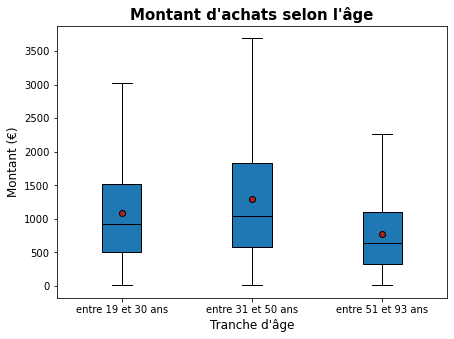

In [330]:
# montant par client avec colonne "tranche d'age"
montant = data.groupby(["client_id", "tranche d'age"])['price'].sum().reset_index()
montant.rename(columns={'price':'montant'}, inplace=True)
montant = montant.sort_values("tranche d'age")

X = "tranche d'age" # qualitative
Y = "montant" # quantitative

modalites = montant[X].unique()
groupes = []
for m in modalites:
    groupes.append(montant[montant[X]==m][Y])

# graphique 
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

plt.figure(figsize=(7,5))
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            patch_artist=True, showmeans=True, meanprops=meanprops)
plt.xlabel("Tranche d'âge", size=12)
plt.ylabel("Montant (€)", size=12)
plt.title("Montant d'achats selon l'âge", size=15, fontweight='bold')
plt.show()

Les points rouges au milieu de chaque boîte à moustaches représentent la moyenne des valeurs.  
* Les montants d'achat maximums sont effectivement effectués par la tranche entre 31 et 50 ans;
* **Les montants d'achats moyens sont presque pareils entre la tranche de 19 à 30 ans et de 31 à 50 ans**;
* **Les personnes de plus de 50 ans possèdent les montants d'achats les plus faibles.**

 ### 3.3 Lien entre l’âge des clients et la taille du panier moyen

On passe à l'analyse  par régression linéaire pour voir si la taille du panier croit ou décroit linéairement selon l'âge.  
D'abord, on va créer une colonne qui s'appelera "taille_panier" en faisant la somme de livres achetés par session par client :

In [332]:
data["taille_panier"]=data["session_id"].value_counts()[data["session_id"]].tolist()
data.head()

,id_prod,date,session_id,client_id,price,categ,sex,birth,age,tranche d'age,taille_panier,mois
0,0_1518,2022-05-20,s_211425,c_103,4.18,0,f,1986,36,entre 31 et 50 ans,2,5
1,0_1518,2021-07-20,s_64849,c_103,4.18,0,f,1986,36,entre 31 et 50 ans,2,7
2,0_1518,2022-08-20,s_255965,c_103,4.18,0,f,1986,36,entre 31 et 50 ans,2,8
3,0_1418,2022-06-18,s_225411,c_103,8.57,0,f,1986,36,entre 31 et 50 ans,3,6
4,0_1418,2021-08-18,s_77214,c_103,8.57,0,f,1986,36,entre 31 et 50 ans,3,8


Ensuite, on calcule la moyenne des tailles du panier par client :

In [333]:
panier = pd.DataFrame(data.groupby(["client_id", "age"])["taille_panier"].mean()).reset_index()
panier["taille_panier"] = round(panier["taille_panier"],2)
panier.rename(columns={"taille_panier": "panier_moyen"}, inplace=True)
panier.head()

,client_id,age,panier_moyen
0,c_1,67,1.63
1,c_10,66,2.17
2,c_100,30,2.00
3,c_1000,56,1.92
4,c_1001,40,3.08


Et on crée un diagramme de dispersion :

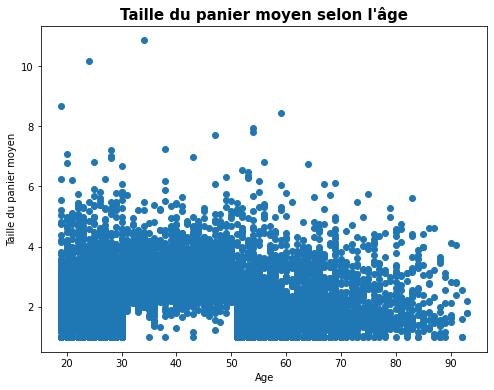

In [334]:
plt.figure(figsize=(8,6))
plt.plot(panier['age'],panier['panier_moyen'], "o")
plt.xlabel("Age")
plt.ylabel("Taille du panier moyen")
plt.title("Taille du panier moyen selon l'âge", size=15, fontweight='bold')
plt.show()

In [335]:
print("Covariance :", round((np.cov(panier["age"],panier["panier_moyen"],ddof=0)[1,0]),2))
print("Pearson :", round((st.pearsonr(panier["age"],panier["panier_moyen"])[0]),2))

Covariance : -3.11
Pearson : -0.2


* **La taille du panier moyen minimum est plus grande entre les 30 et les 50 ans** et **il existe une tendance de décroissance de la taille du panier moyen maximum à partir de 50 ans**.  

Le Pearson étant de -0.2 nous dit qu'il y a une forte correlation entre la taille du panier moyen et l'âge de nos clients.  
Comme auparavant, en étant impossible de tracer une droite avec précision pour toutes les âges, nous allons afficher une boîte à moustaches par tranches d'âge. 

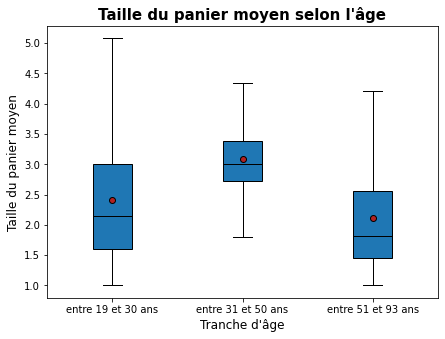

In [350]:
# panier moyen par tranche d'age
panier = pd.DataFrame(data.groupby(["client_id", "tranche d'age"])["taille_panier"].mean()).reset_index()
panier["taille_panier"] = round(panier["taille_panier"],2)
panier.rename(columns={"taille_panier": "panier_moyen"}, inplace=True)
panier = panier.sort_values("tranche d'age")

X = "tranche d'age" # qualitative
Y = "panier_moyen" # quantitative

modalites = panier[X].unique()
groupes = []
for m in modalites:
    groupes.append(panier[panier[X]==m][Y])

# graphique 
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

plt.figure(figsize=(7,5))
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            patch_artist=True, showmeans=True, meanprops=meanprops)
plt.ylabel("Taille du panier moyen", size=12)
plt.xlabel("Tranche d'âge", size=12)
plt.title("Taille du panier moyen selon l'âge", size=15, fontweight='bold')
plt.show()

* **La distribution est plus étalée pour la tranche entre 19 et 30 ans**;
* **La moyenne du panier moyen est plus grande pour la tranche entre 30 et 50 ans, ansi que le panier moyen minimum. Cette tranche présente des paniers plus concentrées**;
* **La tranche entre 51 et 93 ans présente les paniers moyens les plus petits**.

### 3.4 Lien entre l’âge des clients et la fréquence d'achat

Nous allons étudier une corrélation entre l'âge et la fréquence d'achat par mois par régression linéaire.  
Créons d'abord une colonne dans notre table "data" qui va nous indiquer le mois pour chaque achat :

In [342]:
data['date'] = pd.to_datetime(data['date'])
data['mois'] = data['date'].dt.month

Ensuite, nous créons une table qui s'appelera "freq_achat" avec la somme d'achats effectués par mois par personne :

In [343]:
freq_achat = data.pivot_table(index=["client_id", "age", "tranche d'age"], columns=["mois"], values=["taille_panier"], aggfunc=sum).reset_index()
freq_achat = freq_achat.fillna(0)
freq_achat.columns =["client_id", "age", "tranche d'age", '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
freq_achat.head()

,client_id,age,tranche d'age,1,2,3,4,5,6,7,8,9,10,11,12
0,c_1,67,entre 51 et 93 ans,0.0,1.0,2.0,2.0,1.0,4.0,7.0,3.0,2.0,3.0,29.0,3.0
1,c_10,66,entre 51 et 93 ans,0.0,0.0,7.0,34.0,1.0,5.0,5.0,14.0,7.0,8.0,2.0,17.0
2,c_100,30,entre 19 et 30 ans,0.0,0.0,0.0,1.0,0.0,4.0,1.0,9.0,1.0,0.0,0.0,0.0
3,c_1000,56,entre 51 et 93 ans,3.0,41.0,54.0,11.0,26.0,6.0,3.0,11.0,8.0,9.0,5.0,7.0
4,c_1001,40,entre 31 et 50 ans,0.0,25.0,37.0,21.0,1.0,26.0,16.0,9.0,21.0,14.0,34.0,36.0


Et on calcule la moyenne d'achats par mois par personne :

In [344]:
freq_achat["achats_mois"] = freq_achat.iloc[:, 3:15].mean(axis=1)
freq_achat["achats_mois"] = round(freq_achat["achats_mois"],2)
freq_achat=freq_achat[["client_id", "age", "tranche d'age", "achats_mois"]]
freq_achat.head()

,client_id,age,tranche d'age,achats_mois
0,c_1,67,entre 51 et 93 ans,4.75
1,c_10,66,entre 51 et 93 ans,8.33
2,c_100,30,entre 19 et 30 ans,1.33
3,c_1000,56,entre 51 et 93 ans,15.33
4,c_1001,40,entre 31 et 50 ans,20.00


On crée un diagramme en nuage de points:

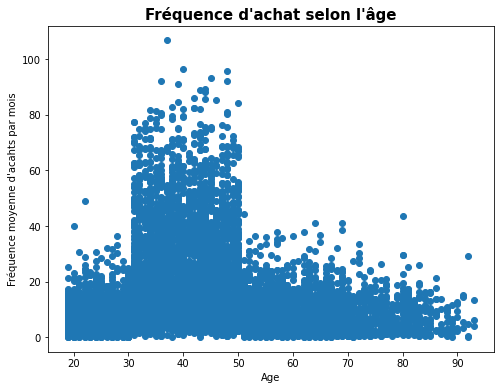

In [345]:
plt.figure(figsize=(8,6))
plt.plot(freq_achat['age'],freq_achat['achats_mois'], "o")
plt.xlabel("Age")
plt.ylabel("Fréquence moyenne d'acahts par mois")
plt.title("Fréquence d'achat selon l'âge", size=15, fontweight='bold')
plt.show()

In [339]:
print("Covariance :", round((np.cov(freq_achat["age"],freq_achat["achats_mois"],ddof=0)[1,0]),2))
print("Pearson :", round((st.pearsonr(freq_achat["age"],freq_achat["achats_mois"])[0]),2))

Covariance : -23.92
Pearson : -0.1


* **Entre 30 et 50 ans, nous avons des fréquences maximum beaucoup plus grandes que pour les autres tranches d'âges**. 
* **La fréquence moyenne maximum d'achats par mois a une à la décroissante à partir des 50 ans**. 

Comme pour l'analyse précédente, nous allons regarder le graphique de boîte à moustaches pour analyser le comportement des différentes tranches d'âges :

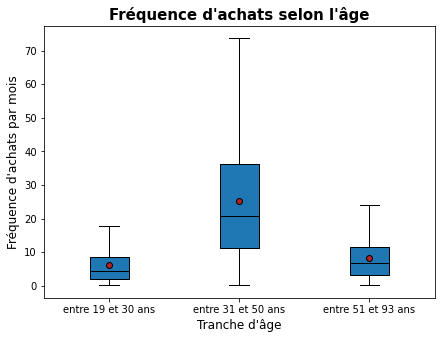

In [347]:
freq_achat = freq_achat.sort_values("tranche d'age")
X = "tranche d'age" # qualitative
Y = "achats_mois" # quantitative

modalites = freq_achat[X].unique()
groupes = []
for m in modalites:
    groupes.append(freq_achat[freq_achat[X]==m][Y])

# graphique 
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

plt.figure(figsize=(7,5))
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            patch_artist=True, showmeans=True, meanprops=meanprops)
plt.xlabel("Tranche d'âge", size=12)
plt.ylabel("Fréquence d'achats par mois", size=12)
plt.title("Fréquence d'achats selon l'âge", size=15, fontweight='bold')
plt.show()

* **Les fréquences d'achats sont plus grandes pour la tranche entre 31 et 50 ans**;  
* **Les tranches de 19 à 30 ans et de 51 à 93 ans ont des fréquences d'achats très proches, avec les personnes plus âgés achetant légèrement plus fréquemment que les jeunes**.

### 3.5 Lien entre l’âge des clients et les catégories des livres achetés

D'abord, on affiche une boîte à moustaches par catégorie :

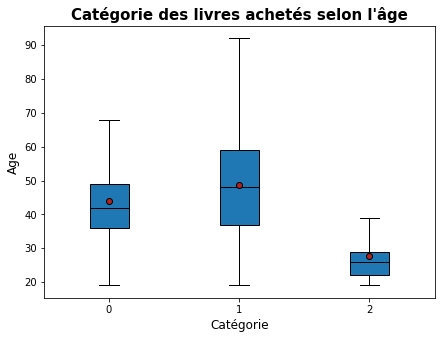

In [314]:
X = "categ" # qualitative
Y = "age" # quantitative

modalites = data[X].unique()
groupes = []
for m in modalites:
    groupes.append(data[data[X]==m][Y])

# graphique 
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

plt.figure(figsize=(7,5))
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            patch_artist=True, showmeans=True, meanprops=meanprops)
plt.ylabel("Age", size=12)
plt.xlabel("Catégorie", size=12)
plt.title("Catégorie des livres achetés selon l'âge", size=15, fontweight='bold')
plt.show()

* **La moyenne d'âge des clients qui achètent des livres de catégorie 2 est plus petite que celle d'autres catégories et sa distribution est plus concentrée**; 
* **Les moyennes d'âge des catégories 0 et 1 sont assez proches, mais la distribution d'âge de la catégorie 1 est plus étalée que celle de la catégorie 0**.  

Nous faisons ensuite une analyse de corrélation entre les variables par ANOVA :

In [348]:
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
print("Eta_squared =", round((eta_squared(data["categ"],data["age"])),2))

Eta_squared = 0.1


Le calcul de $\eta^2$ nous laisse conclure qu'il existe une corrélation moyenne entre l'âge de nos clients et la catégorie des livres achetés. Par contre, nous devons tester les conditions pour l'application du test de corrélation par ANOVA :
1. Indépendance entre les échantillons (condition valide)
2. Egalité des variances entre les trois catégories de livres
3. Test de normalité des résidus  


On testera d'abord la deuxième condition par un test de Bartlett avec 5% de niveau de test avec comme hypothèses :
* H0 : Les variances de chaque catégorie sont égales;
* H1 : Les variances sont différentes entre les catégories.

In [353]:
st.bartlett(data[data['categ']==0]['age'],data[data['categ']==1]['age'],data[data['categ']==2]['age'])

BartlettResult(statistic=22521.104270700904, pvalue=0.0)

La p-value étant inférieure au niveau de test, on rejette l'hypothèse nulle et on peut conclure que la deuxième condition du test n'est pas validée.  

Pour le test de normalité des résidus, troisième condition, nous allons utiliser le test Kolmogorov-Sirnov, une fois que notre échantillon est supérieur à 30. Nos avons comme hypothèses, avec un niveau de test de 5% :
* H0 : les résidus suivent une loi normale;
* H1 : les résidus ne suivent pas une loi normale.

In [355]:
st.ks_2samp(data[data['categ']==0]['age'],list(np.random.normal(np.mean(data[data['categ']==0]['age']), np.std(data[data['categ']==0]['age']), 1000)))

KstestResult(statistic=0.12596927750995934, pvalue=2.998835090909206e-14)

In [356]:
st.ks_2samp(data[data['categ']==1]['age'],list(np.random.normal(np.mean(data[data['categ']==1]['age']), np.std(data[data['categ']==1]['age']), 1000)))

KstestResult(statistic=0.055690523169606876, pvalue=0.004035846340517465)

In [357]:
st.ks_2samp(data[data['categ']==2]['age'],list(np.random.normal(np.mean(data[data['categ']==2]['age']), np.std(data[data['categ']==2]['age']), 1000)))

KstestResult(statistic=0.3056756466481697, pvalue=7.264090077560736e-80)

Les p-values étant inférieures au niveau de test, on rejette l'hypothèse nulle. La troisième condition pour l'application de l'ANOVA n'est pas validée non plus.  

Comme les résidus ne suivent pas une loi normale, nous ne pouvons pas nous fier au test par ANOVA. Ainsi, nous allons utiliser un autre test, cette fois-ci non paramétrique, qui ne prend pas en compte la loi de distribution des données : le test Kruskal-Wallis. Ce test utilisera, au lieu des moyennes, les positions des points sur l'axe : on remplace les valeurs par leur rang. Avec un niveau de test de 5%, on teste les hypothèses :
* H0 : même rang moyen pour chaque catégorie;
* H1 : différents rangs moyens pour au moins 2 catégories.

In [358]:
st.kruskal(data[data['categ']==0]['age'],data[data['categ']==1]['age'],data[data['categ']==2]['age'])

KruskalResult(statistic=52579.77226616652, pvalue=0.0)

La p-value étant inférieure au niveau de test, on rejette l'hypothèse nulle : au moins l'une des catégories possède une distribution différente des autres. Ainsi, **la catégorie des livres achetés dépende de l'âge de nos clients pour au moins deux catégories.**